First import all neccessary modules

In [1]:
from datetime import datetime
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from keras.metrics import Accuracy, Precision, Recall
from keras.optimizers import Adam, RMSprop, SGD, Nadam
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import keras
from positional_encoding import PositionalEncoding, PositionalEncoding2

from preprocessor import Preprocessor
from message_encoder import *

In [ ]:
save_artifacts = True
test_pp = None

# Preprocessor
First we define all hyperparameters used for the preprocessor. If a preprocessor path is defined, the preprocesor will be loaded from that file instead of creating a new preprocessor since that might take a while. 

In [3]:
# === Preprocessing parameters ===
log_files = [i for i in range(745, 754)]            # list of ints representing the numbers of log files to use
logs_per_class = 100                                # int, how many datapoints per class should be collected if available
window_size = 20                                    # int, how many log messages to be considered in a single data point from sliding window
encoding_output_size = 16                           # int, dimensionality of each message's encoded vector representation
message_encoder = BERTEncoder(encoding_output_size) # encoder object, can be TextVectorizationEncoder, BERTEncoder, or BERTEmbeddingEncoder
extended_datetime_features = False                  # bool, whether to use additional normalized datetime features
preprocessor_file = "../data/preprocessors/preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip"  # str (path), if not empty and exists, loads existing preprocessor file instead of creating one

In the next block data is loaded and preprocessed either using a new preprocessor with the parameters above or using a preprocessor loaded from a file. The former might take a while depending on number and size of the log files. 

In [4]:
# === Load or preprocess data ===
if os.path.isfile(preprocessor_file):
    print("loading preprocessor from file")
    pp = Preprocessor.load(preprocessor_file)
else:
    pp = Preprocessor(log_files, message_encoder,
                      logs_per_class=logs_per_class,
                      window_size=window_size,
                      extended_datetime_features=extended_datetime_features,
                      volatile=True)
    pp.preprocess()
    path = f"./data/preprocessors/preprocessor_{len(pp.loaded_files)}files_"
    enc_type = "BERTenc" if isinstance(pp.message_encoder, BERTEncoder) else "BERTemb" if isinstance(pp.message_encoder, BERTEmbeddingEncoder) else "TextVec"
    path += f"{logs_per_class}lpc_{window_size}ws_{enc_type}x{encoding_output_size}"
    if extended_datetime_features:
        path += "_extdt"
    path += ".json"
    if not os.path.isfile(path):
        pp.save(path)


loading preprocessor from file


# Transformer Architecture
Next we define the hyperparameters used by the transformer architecture. 

In [113]:
# === Transformer Hyperparameters ===
model_dim = 128                                     # int, dimension of the transformer hidden layers; must be divisible by num_heads
num_heads = 4                                       # int, number of attention heads in multi-head attention; must divide model_dim evenly
ff_dim = 256                                        # int, dimension of the feed-forward layer inside each transformer block
num_transformer_blocks = 1                          # int, how many stacked transformer blocks to use; generally 1–6 for lightweight models
dropout_rate = 0                                  # float in range [0.0, 1.0], dropout rate for regularization; 0.0 disables dropout

num_classes = len(set(pp.data.data_array_y))
input_shape = pp.data.entry_shape

Then we can create the model itself using the parameters. 

In [114]:
# === Transformer Block ===
def transformer_block(x, model_dim, num_heads, ff_dim, dropout_rate):
    # Multi-Head Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim // num_heads)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    x = Add()([x, attn_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    # Feed-Forward Network
    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dense(model_dim)(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    x = Add()([x, ff_output])
    x = LayerNormalization(epsilon=1e-6)(x)

    return x

# === Build Transformer Model ===
inputs = Input(shape=input_shape)
x = Dense(model_dim)(inputs)  # Project to model dimension
x = PositionalEncoding()(x)

# Apply multiple transformer blocks
for _ in range(num_transformer_blocks):
    x = transformer_block(x, model_dim, num_heads, ff_dim, dropout_rate)

x = GlobalAveragePooling1D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

# Training
Next we define the training parameters and split the data into unlabeled, labeled and test data. The unlabeled data currently is just extracted from the dataset while discarding the labels. That is done in order to assure that the class ratios can stay the same. 

In [115]:
# === Training hyperparameters ===
split_ratios = (4, 1)                               # tuple of ints, ratio of data split for training and testing
epochs = 1000                                       # int, number of iterations (epochs) to train the model
batch_size = 32                                     # int, number of samples per training batch
early_stopping_monitor = "val_loss"                 # str, metric to monitor for early stopping; options: 'loss', 'val_loss', 'accuracy', 'val_accuracy', etc.
early_stopping_patience = 100000                        # int, number of epochs with no improvement after which training will be stopped
early_stopping_restore_best = True                  # bool, whether to restore model weights from the epoch with the best monitored value
validation_split = 0.2                              # float in range (0.0, 1.0), fraction of training data to reserve for validation
learning_rate = 0.001 # 0.001                               # float > 0.0, learning rate used by the optimizer
optimizer = Adam(learning_rate=learning_rate)       # optimizer instance, can be Adam, RMSprop, SGD (optionally with momentum), or Nadam

# === Prepare data ===
train, test = pp.data.stratified_split(split_ratios)
X_train, y_train = train
X_test, y_test = test
num_classes = len(set(y_train))

filename = f"../models/transformer_{num_transformer_blocks}x{model_dim}_heads{num_heads}_ffdim{ff_dim}_drop{dropout_rate}_lr{learning_rate}_bs{batch_size}_ep{epochs}_earlystp{early_stopping_monitor}{early_stopping_patience}{early_stopping_restore_best}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

Compile the model.

In [116]:
# Compile model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# === Training ===
early_stopping = EarlyStopping(monitor=early_stopping_monitor,
                               patience=early_stopping_patience,
                               restore_best_weights=early_stopping_restore_best)

train the model

In [117]:
history = model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=validation_split,
          callbacks=[early_stopping])

Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.4834 - loss: 1.1244 - val_accuracy: 0.7812 - val_loss: 0.6776
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7125 - loss: 0.6226 - val_accuracy: 0.8906 - val_loss: 0.4291
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8261 - loss: 0.4653 - val_accuracy: 0.8125 - val_loss: 0.3743
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8394 - loss: 0.3854 - val_accuracy: 0.8594 - val_loss: 0.3240
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8935 - loss: 0.2954 - val_accuracy: 0.8750 - val_loss: 0.3273
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8812 - loss: 0.2637 - val_accuracy: 0.8750 - val_loss: 0.3116
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8961 - loss: 0.2444 - val_accuracy: 0.8906 - val_loss: 0.2772
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9088 - loss: 0.2038 - val_accuracy: 0.8750 - v

# Evaluating and Testing
Plot loss, validation loss, accuracy and validation accuracy of the training process.

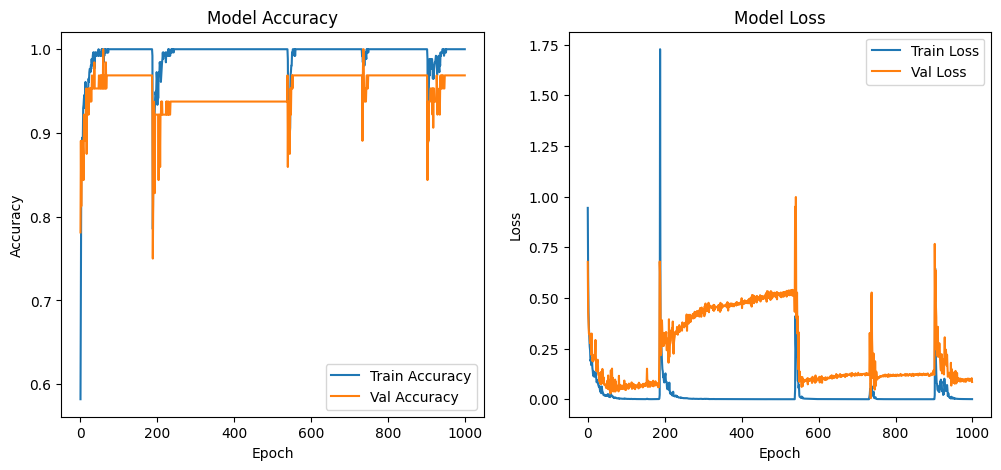

In [118]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

#plt.tight_layout()
plt.savefig(f"{filename}_train.png")
plt.show()


Optionally save the weights of the model

In [119]:
# === Save model ===
if save_artifacts: model.save(f"{filename}.keras")

Evaluate model and print scores

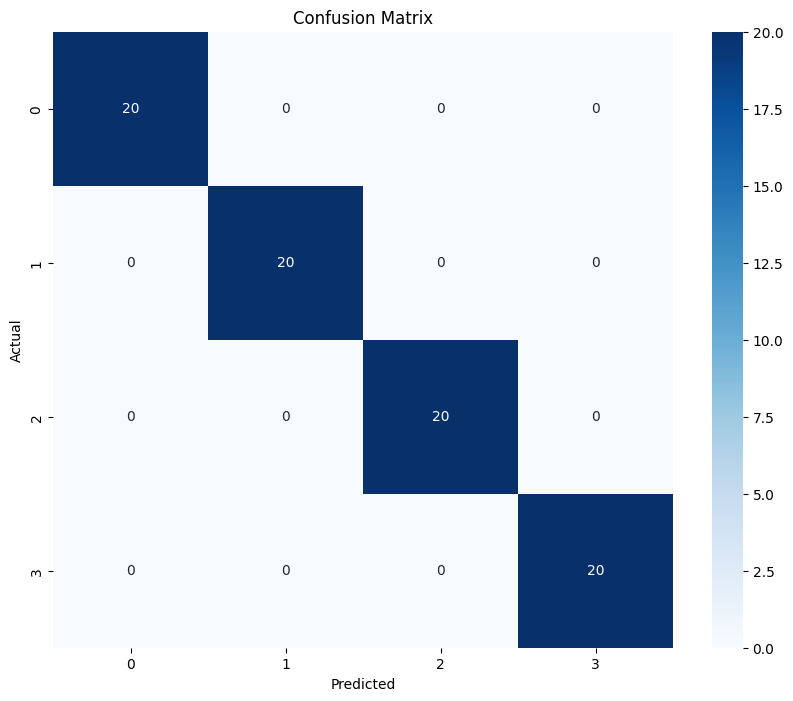

In [120]:
if save_artifacts:
    f = open(f"{filename}.txt", "w")
    ostd = sys.stdout
    sys.stdout = f

# Summary of the model
model.summary(print_fn = f.write if save_artifacts else None)


results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# === Predictions & Report ===
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

# === Confusion Matrix ===
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
if save_artifacts: plt.savefig(f"{filename}.png")
plt.show()

# === Preview Predictions ===
for i in range(min(80, len(y_pred))):
    print(f"True: {y_test[i]}, Pred: {y_pred[i]}, Prob: {predictions[i]}")

if save_artifacts:
    sys.stdout = ostd
    f.close()

Test on larger test dataset (3 newest files)

In [121]:
import numpy as np
import random
import os
import tensorflow as tf
from preprocessor import Preprocessor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from test_models import load_model, test_random_line

In [122]:
# preprocessor_path = "../data/preprocessors/preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip"
if test_pp is None:
    test_preprocessor_path = "../data/preprocessors/preprocessor_3_newest_files_100lpc_20ws_BERTencx16.zip"
    test_pp = Preprocessor.load(test_preprocessor_path)
    print(test_pp.data.states_counts)
    test_X, test_y = test_pp.data.as_xy_arrays()

In [123]:
# Get predictions
y_pred_probs = model.predict(test_X)
y_pred = y_pred_probs.argmax(axis=1)  # For softmax outputs

# True labels
y_true = test_y.argmax(axis=1) if test_y.ndim > 1 else test_y

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

if save_artifacts:
    f = open(f"{filename}-test.txt", "w")
    ostd = sys.stdout
    sys.stdout = f

print("test with test data (3 newest files)")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

if save_artifacts:
    f.close()
    sys.stdout = ostd

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


d:\mgeo\projects\log-classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


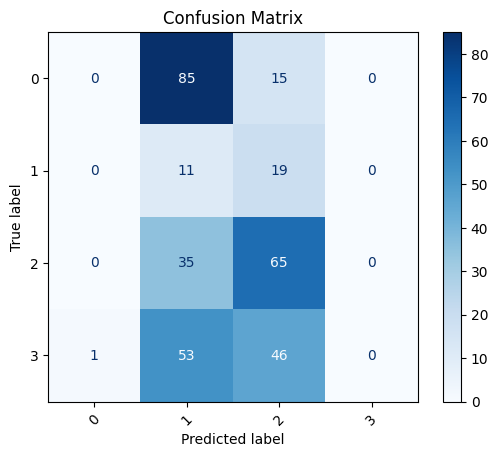

In [124]:
# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.savefig(f"{filename}_test-confusionmatrix.png")
plt.show()